In [1]:
import pickle

import sys
sys.path.append('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/')
from model_and_circuit import *

# from jax.lib import xla_bridge
# jax.experimental.enable_x64()
# print("JAX Backend:", xla_bridge.get_backend().platform)

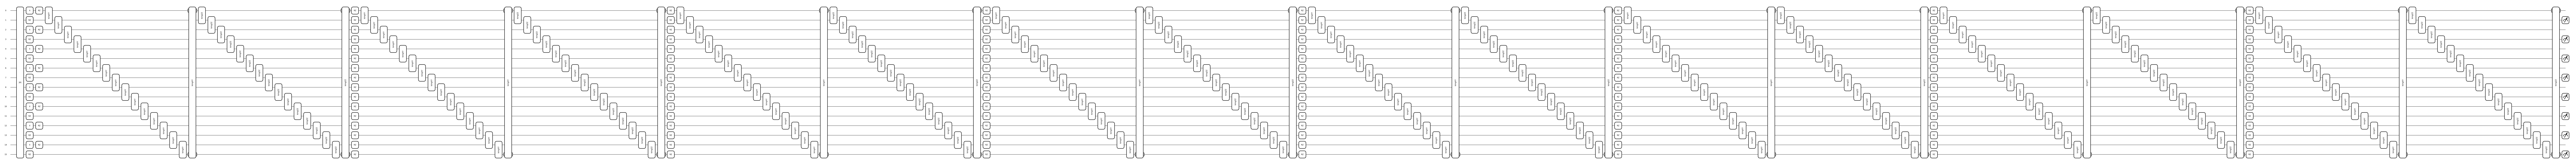

In [2]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.draw()

In [3]:
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/cat_distribution.pkl', 'rb') as f:
    cat_distribution = pickle.load(f)

target_distribution = cat_distribution

In [11]:
a = np.real(np.conj(target_distribution) @ target_distribution)
a

Array(0.00524856, dtype=float32)

In [4]:
from functools import partial
from autograd import grad

#Loss Function
class FidelityLoss:
    # def __init__(self,py):
    #     self.py = py
    
    def __call__(self,density,py):
        fidelity = np.real(np.conj(py) @ density @ py)
        print(np.shape(density))
        print(fidelity)
        return -fidelity
    
class QCBM:
    def __init__(self,circ,loss,py):
        self.circ = circ
        self.loss = loss
        self.py = py
    
    def fidelity_loss(self,params):
        density_matrix = self.circ(params)
        return self.loss(density_matrix,self.py)

#Model Training
# @jit
def update_step(params,opt_state):
    
    gradient_fn = grad(qcbm.fidelity_loss)
    grads = gradient_fn(params)
    loss_val = qcbm.fidelity_loss(params)
    
    # loss_val, grads = jax.value_and_grad(qcbm.fidelity_loss,has_aux=False)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)

    return params, opt_state, loss_val

In [5]:
# from pennylane.math import is_abstract
# d = circuit(initial_params)
# print(is_abstract(d))


In [ ]:
loss = FidelityLoss()

qcbm = QCBM(circuit,loss,py=target_distribution)

weights = initial_params
lr = 0.1
opt = optax.adam(lr)
opt_state = opt.init(weights)

neg_fidelities = []
parameters = []

fidelity = 0
i = 0

while i < 500:
    i+=1
    current_lr = lr
    start_time = time.time()
    weights, opt_state, fidelity = update_step(weights,opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
        
    neg_fidelities.append(fidelity)
    parameters.append(weights)